Notebook da competição do Kaggle House Prices: Advanced Regression Techniques
(https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

Melhor score: 0.14229, posição 2183

- Primeira submissão: todas as variáveis presentes
- Segunda submissão: deixei apenas as variáveis cujas importâncias (obtidas a partir da primeira submissão) eram maiores que 0.3; o resultado foi pior do que o inicial
- Terceira submissão: voltei todas as variáveis; modificação no número de estimators (2500) e no max_features (0.5); subi 129 posições (score 0.14546 -> 0.14229)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "data/"

In [4]:
!ls {PATH}

sample_submission.csv  test.csv  train.csv


In [4]:
df_train = pd.read_csv(f'{PATH}/train.csv')
df_test = pd.read_csv(f'{PATH}/test.csv')

In [6]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
display_all(df_train.T)

In [8]:
display_all(df_train.describe(include='all').T)

In [9]:
display_all(df_test.describe(include='all').T)

In [6]:
#concatenando os sets para facilitar o pré-processamento
df_all = df_train.append(df_test, sort= False)
df_all.shape

(2919, 81)

A métrica sugerida pelo Kaggle é a RMLSE (root mean squared log error) entre o valor de venda previsto e atual. Logo, para facilitar, substituimos a variável alvo (dependente) - SalePrice - pelo seu log.

In [8]:
df_all.SalePrice = np.log(df_all.SalePrice)

In [14]:
(df_train.isnull().sum()/len(df_train)).sort_values(ascending=False)

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
FireplaceQu      0.472603
LotFrontage      0.177397
GarageCond       0.055479
GarageType       0.055479
GarageYrBlt      0.055479
GarageFinish     0.055479
GarageQual       0.055479
BsmtExposure     0.026027
BsmtFinType2     0.026027
BsmtFinType1     0.025342
BsmtCond         0.025342
BsmtQual         0.025342
MasVnrArea       0.005479
MasVnrType       0.005479
Electrical       0.000685
Utilities        0.000000
YearRemodAdd     0.000000
MSSubClass       0.000000
Foundation       0.000000
ExterCond        0.000000
ExterQual        0.000000
Exterior2nd      0.000000
Exterior1st      0.000000
RoofMatl         0.000000
RoofStyle        0.000000
YearBuilt        0.000000
                   ...   
GarageArea       0.000000
PavedDrive       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
3SsnPorch        0.000000
BsmtUnfSF        0.000000
ScreenPorch      0.000000
PoolArea    

In [13]:
(df_test.isnull().sum()/len(df_test)).sort_values(ascending=False)

PoolQC           0.997944
MiscFeature      0.965045
Alley            0.926662
Fence            0.801234
FireplaceQu      0.500343
LotFrontage      0.155586
GarageCond       0.053461
GarageQual       0.053461
GarageYrBlt      0.053461
GarageFinish     0.053461
GarageType       0.052090
BsmtCond         0.030843
BsmtQual         0.030158
BsmtExposure     0.030158
BsmtFinType1     0.028787
BsmtFinType2     0.028787
MasVnrType       0.010966
MasVnrArea       0.010281
MSZoning         0.002742
BsmtHalfBath     0.001371
Utilities        0.001371
Functional       0.001371
BsmtFullBath     0.001371
BsmtFinSF2       0.000685
BsmtFinSF1       0.000685
Exterior2nd      0.000685
BsmtUnfSF        0.000685
TotalBsmtSF      0.000685
SaleType         0.000685
Exterior1st      0.000685
                   ...   
OverallQual      0.000000
SaleCondition    0.000000
Heating          0.000000
ExterQual        0.000000
TotRmsAbvGrd     0.000000
YrSold           0.000000
MoSold           0.000000
MiscVal     

As seguintes features contém muitos valores inexistentes, tanto no set de treino como no set de test:

- Alley: tipo de acesso ao jardim (cascalho, pavimentado)
- PoolQC: qualidade da piscina
- MiscFeature: outras características não disponíveis em outras categorias (elevador, segunda garagem, quadra de tênis)
- Fence: qualidade da cerca

Os 2 últimos, aparentemente, podem influenciar mais fortemente no preço da casa. O primeiro, inicialmente, acredito que não.

Nota: após a primeira execução, a listagem de features importantes mostrou que essas colunas não influenciam no resultado. Nesta segunda vez, vou removê-las - além de outras que não afetam o resultado.

Na listagem de importância, essas foram as features que mais contribuíram para o resultado:

- Variable: OverallQual          Importance: 0.25
- Variable: GrLivArea            Importance: 0.13
- Variable: GarageCars           Importance: 0.1
- Variable: ExterQual            Importance: 0.09
- Variable: TotalBsmtSF          Importance: 0.05
- Variable: YearBuilt            Importance: 0.04
- Variable: KitchenQual          Importance: 0.04
- Variable: 1stFlrSF             Importance: 0.03
- Variable: 2ndFlrSF             Importance: 0.03
- Variable: GarageArea           Importance: 0.03


Vou dropar todas as que não estão listadas acima.

In [7]:
important_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'ExternQual', 'TotalBsmtSF', 'YearBuilt', 'KitchenQual', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'SalePrice']
cols_drop = [col for col in df_all.columns.tolist() if col not in important_cols]

In [8]:
df_all.drop(columns=cols_drop, inplace=True)

In [9]:
df_all.sample(10)

,OverallQual,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageCars,GarageArea,SalePrice
980,7,1961,944.0,999,0,999,Ex,2.0,588.0,178400.0
1131,5,1991,974.0,974,0,974,TA,0.0,0.0,93500.0
144,8,1998,1049.0,1036,880,1916,Gd,3.0,741.0,NaN
1066,6,1993,799.0,799,772,1571,TA,2.0,380.0,178000.0
119,6,2005,728.0,728,728,1456,Gd,2.0,390.0,163990.0
1049,8,2006,1489.0,1500,0,1500,Gd,2.0,674.0,NaN
662,6,1968,1392.0,1392,0,1392,TA,2.0,576.0,110000.0
1389,8,1999,1090.0,1090,1124,2214,Gd,3.0,646.0,NaN
1226,6,2007,894.0,894,1039,1933,Gd,3.0,668.0,214000.0
1117,5,1922,816.0,816,0,816,TA,1.0,100.0,NaN


In [9]:
# descoberta de colunas que não tem valor numéricos; devem ser categorizadas
columns_not_numeric = [column for column in df_all.columns.tolist() if column not in df_all._get_numeric_data().columns.tolist()]
columns_not_numeric

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [10]:
train_cats(df_all)

As variáveis categóricas acima estão fora de uma ordem natural. Vamos ordená-las.

Ordenação baseada na descrição disponível em https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/data_description.txt?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1532350002&Signature=WEhsZeEBZXj9X40gvQ%2BbvvtbDWygObtCJzlxjyoHfhBWz4o%2FxYPOvXHbviknMHCMquH5vVQSivCjjAfOG9lxM0PGrFGWzjF3Zdj%2Bq5lRc7iK29sZ02Fr7LONmoYtZMHeEaFKmTCmrVN0QvSEqsWcA5bBZXE6tIAHZP9rAaWF80PUF6DzPpHKMM4SRkTlvXjCXrsq5uOWbu0XOTfrz9%2F3qtU78a7j9G0n0xetfjE2t9YFA7h5Us6ylxUqCElzjiRH4lkjpyQMMbI%2BCtm6FgU5WA8qLdiyzc%2BShwYAKYTCcQyDr8H4L6tbYiUaUFpFXLLmEK5wnd5h3RkwRmb6J3ZVVw%3D%3D

In [12]:
df_all.ExterQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace = True)
df_all.ExterCond.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace = True)
df_all.BsmtQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
df_all.BsmtCond.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
df_all.BsmtExposure.cat.set_categories(['Gd', 'Av', 'Mn', 'No', 'NA'], ordered=True, inplace = True)
df_all.BsmtFinType1.cat.set_categories(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], ordered=True, inplace = True)
df_all.BsmtFinType2.cat.set_categories(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], ordered=True, inplace = True)
df_all.HeatingQC.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace = True)
df_all.KitchenQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace = True)
df_all.FireplaceQu.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
df_all.GarageFinish.cat.set_categories(['Fin', 'RFn', 'Un', 'NA'], ordered=True, inplace = True)
df_all.GarageQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
df_all.GarageCond.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True, inplace = True)
df_all.PoolQC.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'NA'], ordered=True, inplace = True)

Atribuindo valores numéricos às variáveis categóricas.

In [13]:
for column in columns_not_numeric:
    df_all[column] = df_all[column].cat.codes

In [16]:
display_all(df_all.head(15))

,OverallQual,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageCars,GarageArea,SalePrice
0,7,2003,856.0,856,854,1710,1,2.0,548.0,208500.0
1,6,1976,1262.0,1262,0,1262,2,2.0,460.0,181500.0
2,7,2001,920.0,920,866,1786,1,2.0,608.0,223500.0
3,7,1915,756.0,961,756,1717,1,3.0,642.0,140000.0
4,8,2000,1145.0,1145,1053,2198,1,3.0,836.0,250000.0
5,5,1993,796.0,796,566,1362,2,2.0,480.0,143000.0
6,8,2004,1686.0,1694,0,1694,1,2.0,636.0,307000.0
7,7,1973,1107.0,1107,983,2090,2,2.0,484.0,200000.0
8,7,1931,952.0,1022,752,1774,2,2.0,468.0,129900.0
9,5,1939,991.0,1077,0,1077,2,1.0,205.0,118000.0


In [14]:
# Separando novamente os sets de treino e test
df_test = df_all.iloc[1460:].copy()
df_train = df_all.iloc[:1460].copy()

In [18]:
df_train.shape,df_test.shape

((1460, 10), (1459, 10))

In [15]:
df, y, nas = proc_df(df_train, 'SalePrice')

In [33]:
display_all(df.sample(10))

,OverallQual,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageCars,GarageArea
355,6,1995,1200.0,1200,0,1200,1,2.0,521.0
1114,5,1954,833.0,833,0,833,1,1.0,326.0
1120,6,1920,1012.0,1012,0,1012,2,1.0,308.0
1188,7,2002,831.0,831,829,1660,1,2.0,493.0
1135,6,1926,960.0,986,0,986,2,1.0,180.0
526,5,1956,928.0,928,0,928,2,1.0,252.0
1019,7,2005,1362.0,1506,0,1506,1,2.0,440.0
1367,5,1977,757.0,925,550,1475,2,1.0,336.0
511,7,2005,1368.0,1368,0,1368,1,2.0,474.0
1424,5,1958,1024.0,1344,0,1344,2,1.0,484.0


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.20, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1168, 83), (1168,), (292, 83), (292,))

In [17]:
m = RandomForestRegressor(n_jobs=-1, random_state=42)
m.fit(df,y)
m.score(df, y)

0.9741525904497369

In [18]:
#def mse(x,y):
#    return metrics.mean_squared_error(x,y)

#def rmse(x,y): return np.sqrt(mse(x,y))

#def print_score(m):
#    res = [rmse(np.log(y_train), np.log(m.predict(X_train))), rmse(np.log(y_test), np.log(m.predict(X_test)))]
#    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
#    print(res)
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [19]:
m = RandomForestRegressor(n_jobs=-1, random_state=42)
m.fit(df,y)
print_score(m)

[0.062097818621673274, 0.07199038020421834, 0.9747046177264868, 0.9722280845964042]


O valor acima já nos dá uma boa posição, aparentemente. Ainda temos um overfitting considerável.

Vamos melhorar os parâmetros.

In [22]:
# aumentando o número de árvores --> 2500 parece ser o melhor
for n in range(1000,2501,250):
    m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=n, oob_score=True)
    m.fit(df,y)
    print(n, end =": ")
    print_score(m)

1000: [0.051206442345081524, 0.052787334651510365, 0.9827996309550433, 0.9850680554883007, 0.8771632057749037]
1250: [0.05140788596709334, 0.0527526913372935, 0.9826640339534374, 0.9850876481540256, 0.8767289916685618]
1500: [0.05147490950521042, 0.05268889208227888, 0.9826188006126716, 0.9851236964239093, 0.8765847017896184]
1750: [0.05144948197992598, 0.05268068491132991, 0.9826359682670275, 0.9851283305261935, 0.8767137401824738]
2000: [0.051486613512436434, 0.05268465686647112, 0.9826108956814188, 0.9851260878890314, 0.8767447181793622]
2250: [0.05147165646249696, 0.052711686424979955, 0.9826209974109927, 0.9851108220248307, 0.8767007727591548]
2500: [0.05140736034680758, 0.0524611377836011, 0.9826643884550347, 0.9852520278091856, 0.8769426015227395]


In [25]:
# 2500 estimators nos parece ser o melhor resultado
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=2500, oob_score=True)
m.fit(df,y)
print_score(m)

[0.051337933099746505, 0.0526595482362543, 0.982711181406562, 0.9851402618283915, 0.8762967730234049]


In [64]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=2500, oob_score=True)
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=359, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [29]:
?RandomForestRegressor

In [26]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=2500, oob_score=True, min_samples_leaf=1)
m.fit(df,y)
print_score(m)

[0.05140736034680759, 0.052461137783601085, 0.9826643884550347, 0.9852520278091856, 0.8769426015227395]


In [29]:
# entre 0.1 e 0.6 não melhorou
# entre 0.01 e 0.1 também não melhorou
n_estimators = 2500
for msl in [1,2,5,10]: #np.arange(0.01,0.1,0.01):
    m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=n_estimators, min_samples_leaf=msl, oob_score=True)
    m.fit(df,y)
    print(msl, end =": ")
    print_score(m)

1: [0.05140736034680758, 0.0524611377836011, 0.9826643884550347, 0.9852520278091856, 0.8769426015227395]
2: [0.06226667466798278, 0.06119942378851385, 0.9745668645636975, 0.9799298062261984, 0.8772031694374681]
5: [0.09036286157697589, 0.09276530955898689, 0.9464365540556153, 0.9538864990148068, 0.8700189473003596]
10: [0.11454034755800813, 0.12008267191113597, 0.9139391658507399, 0.9227288128496546, 0.858801517510811]


Até agora, n_estimators = 2500 e min_samples_leaf = 1 (valor padrão) é a melhor combinação.

In [30]:
n_estimators = 2500
min_samples_leaf = 1

max_features = [0.3,0.35,0.4,0.45,0.5,'auto','log2','sqrt',None]
for mf in max_features:
    m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=mf, oob_score=True)
    m.fit(df,y)
    print(mf, end =": ")
    print_score(m)

0.3: [0.049407921054689365, 0.05241723285342374, 0.98398666759646, 0.9852767027501179, 0.8844117942645605]
0.35: [0.04935558104313832, 0.052131598896972484, 0.984020576898719, 0.9854367270438326, 0.8848714679119787]
0.4: [0.04931128002053485, 0.05206890891542367, 0.9840492499308381, 0.9854717316242803, 0.8850876776856794]
0.45: [0.04947897371261938, 0.05193475526062548, 0.9839405774990424, 0.9855464982960231, 0.8846180597007698]
0.5: [0.04952836588630328, 0.051838046391694634, 0.9839084989963969, 0.985600276555861, 0.8845301083407711]
auto: [0.051407360346807596, 0.05246113778360111, 0.9826643884550347, 0.9852520278091856, 0.8769426015227395]
log2: [0.050989943677609, 0.05566427525879703, 0.9829447683500026, 0.9833961035128703, 0.8752013391426671]
sqrt: [0.04998840279932146, 0.054552293042668856, 0.983608183664561, 0.9840528558479884, 0.8800973272991628]
None: [0.05140736034680758, 0.052461137783601106, 0.9826643884550347, 0.9852520278091856, 0.8769426015227395]


O valor <s>padrão de max_features</s> 0.5 é o que, aparentemente, traz o melhor resultado.

In [31]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=0.5, oob_score=True)
m.fit(df,y)
print_score(m)

[0.04952836588630328, 0.05183804639169466, 0.9839084989963969, 0.985600276555861, 0.8845301083407711]


In [32]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=0.5, oob_score=True)
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2500, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

Vamos fazer a busca randômica de hiperparâmetros para, apenas verificar, se há uma combinação melhor do que aquela descoberta até agora (n_estimators = 2500, min_samples_leaf = 1 e max_features = 0.5)

In [33]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in range(1000,3100,100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.3, 0.35, 0.4, 0.45, 0.5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(0.01, 0.5, 0.01).tolist()
min_samples_leaf.append(1)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000], 'max_features': ['auto', 'sqrt', 0.3, 0.35, 0.4, 0.45, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.06999999999999999, 0.08, 0.09, 0.09999999999999999, 0.11, 0.12, 0.13, 0.14, 0.15000000000000002, 0.16, 0.17, 0.18000000000000002, 0.19, 0.2, 0.21000000000000002, 0.22, 0.23, 0.24000000000000002, 0.25, 0.26, 0.27, 0.28, 0.29000000000000004, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36000000000000004, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42000000000000004, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48000000000000004, 0.49, 1], 'bootstrap': [True, False]}


In [32]:
#from sklearn.metrics import make_scorer

#def scorer(x,y):
#    return rmse(np.log(x), np.log(y))

#eval_scorer = make_scorer(score_func=scorer, greater_is_better=False)

In [37]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1, scoring='mean_squared_log_error')
# Fit the random search model
rf_random.fit(X_train, y_train)

ValueError: 'mean_squared_log_error' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

In [35]:
rf_random.best_params_

{'n_estimators': 1900,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 0.35,
 'max_depth': 60,
 'bootstrap': False}

In [39]:
m = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=2500, min_samples_leaf=1, max_features=0.5, oob_score=True)
m.fit(df,y)
print_score(m)
# [0.04952836588630328, 0.05183804639169466, 0.9839084989963969, 0.985600276555861, 0.8845301083407711]

[0.04952836588630328, 0.05183804639169466, 0.9839084989963969, 0.985600276555861, 0.8845301083407711]


Para análise posteriores, vamos listar as features mais importantes.

In [72]:
?plt.axes

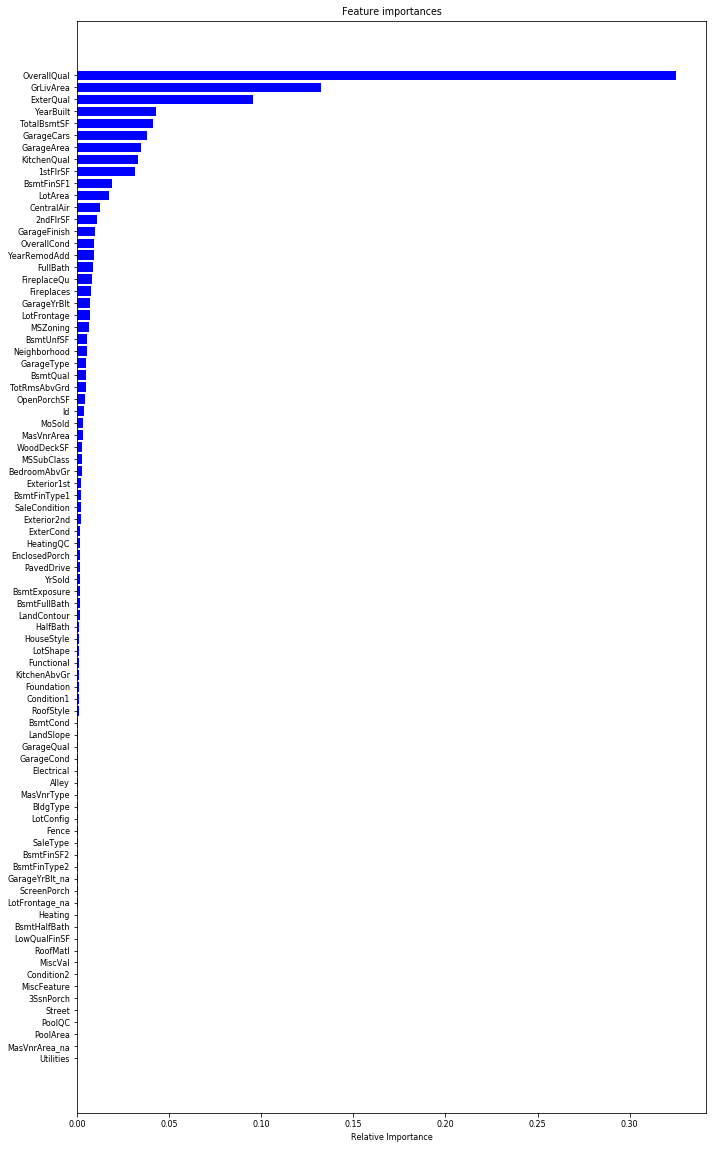

In [77]:
feature_list = list(df.columns)
# Get numerical feature importances
importances = list(m.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

indices = np.argsort(importances)

matplotlib.rcParams.update({'font.size': 8})
#plt.figure(figsize=(200,200))

plt.figure(figsize=(10,16))
plt.title("Feature importances")
plt.barh(range(len(indices)), m.feature_importances_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_list[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

Do resultado anterior, confirmou-se a hipótese de que a variáveis com muitos valores nulos não contribuem para o resultado do modelo: Alley, PoolQC, MiscFeature e Fence.

In [89]:
df_test.sample(10).T

,559,1431,1350,371,889,576,1214,161,269,1038
Id,2020.0,2892.0,2811.0,1832.0,2350.0,2037.0,2675.0,1622.0,1730.0,2499.0
MSSubClass,190.0,30.0,20.0,90.0,60.0,160.0,120.0,50.0,90.0,30.0
MSZoning,3.0,0.0,3.0,4.0,1.0,1.0,3.0,3.0,3.0,3.0
LotFrontage,65.0,69.0,NaN,50.0,112.0,24.0,43.0,68.0,75.0,NaN
LotArea,8450.0,12366.0,9535.0,3000.0,12217.0,2645.0,3010.0,10544.0,8250.0,11515.0
Street,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Alley,-1.0,-1.0,-1.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
LotShape,3.0,3.0,0.0,3.0,0.0,3.0,3.0,0.0,3.0,0.0
LandContour,3.0,3.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0
Utilities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
df, y, nas = proc_df(df_test, 'SalePrice')

In [91]:
# Para o número de colunas treinados ser igual as colunas do conjunto de teste
df.drop(columns=['BsmtFinSF1_na', 'BsmtFinSF2_na', 'BsmtUnfSF_na', 'TotalBsmtSF_na', 'BsmtFullBath_na', 'BsmtHalfBath_na', 'GarageCars_na', 'GarageArea_na'], inplace=True)

In [92]:
predictions = m.predict(df)

In [93]:
df['SalePrice'] = pd.Series(predictions)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na,SalePrice
0,1461,20,2,80.0,11622,1,-1,3,3,0,...,-1,0,6,2010,8,4,False,False,False,11.741904
1,1462,20,3,81.0,14267,1,-1,0,3,0,...,0,12500,6,2010,8,4,False,False,False,11.930591
2,1463,60,3,74.0,13830,1,-1,0,3,0,...,-1,0,3,2010,8,4,False,False,False,12.078611
3,1464,60,3,78.0,9978,1,-1,0,3,0,...,-1,0,6,2010,8,4,False,False,False,12.116447
4,1465,120,3,43.0,5005,1,-1,0,1,0,...,-1,0,1,2010,8,4,False,False,False,12.181525


In [99]:
#df_temp = pd.read_csv(f'{PATH}test.csv')
#print(df['SalePrice'][0])
#print(np.exp(df['SalePrice'][0]))
kaggle_sub = pd.DataFrame({ 'Id': df['Id'],'SalePrice': np.exp(df['SalePrice']) })
display_all(kaggle_sub)

,Id,SalePrice
0,1461,125731.567214
1,1462,151841.283279
2,1463,176065.454781
3,1464,182854.590804
4,1465,195150.178964
5,1466,182766.633741
6,1467,165531.008358
7,1468,175141.642587
8,1469,179933.980972
9,1470,121553.864059


In [100]:
kaggle_sub.to_csv(f'{PATH}preds_with_2500_estimators.csv', index=False)

In [101]:
len(kaggle_sub)

1459